In [ ]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [ ]:
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(1, 1)

In [ ]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... compound
d823 ... pobj


In [ ]:
def get_entities(sent):

  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""
  prv_tok_text = ""

  prefix = ""



  for tok in nlp(sent):

    if tok.dep_ != "punct":

      if tok.dep_ == "compound":
        prefix = tok.text

        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text



      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text

      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text


  return [ent1.strip(), ent2.strip()]

In [ ]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentance"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 1/1 [00:00<00:00, 49.48it/s]


In [ ]:
def get_relation(sent):

  doc = nlp(sent)


  matcher = Matcher(nlp.vocab)
  pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},
            {'POS':'ADJ','OP':"?"}]

  matcher.add("matching_1", [pattern])

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]]

  return(span.text)

In [ ]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentance'])]

100%|██████████| 1/1 [00:00<00:00, 62.06it/s]


In [ ]:

source = [i[0] for i in entity_pairs]


target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [ ]:

G=nx.from_pandas_edgelist(kg_df, "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

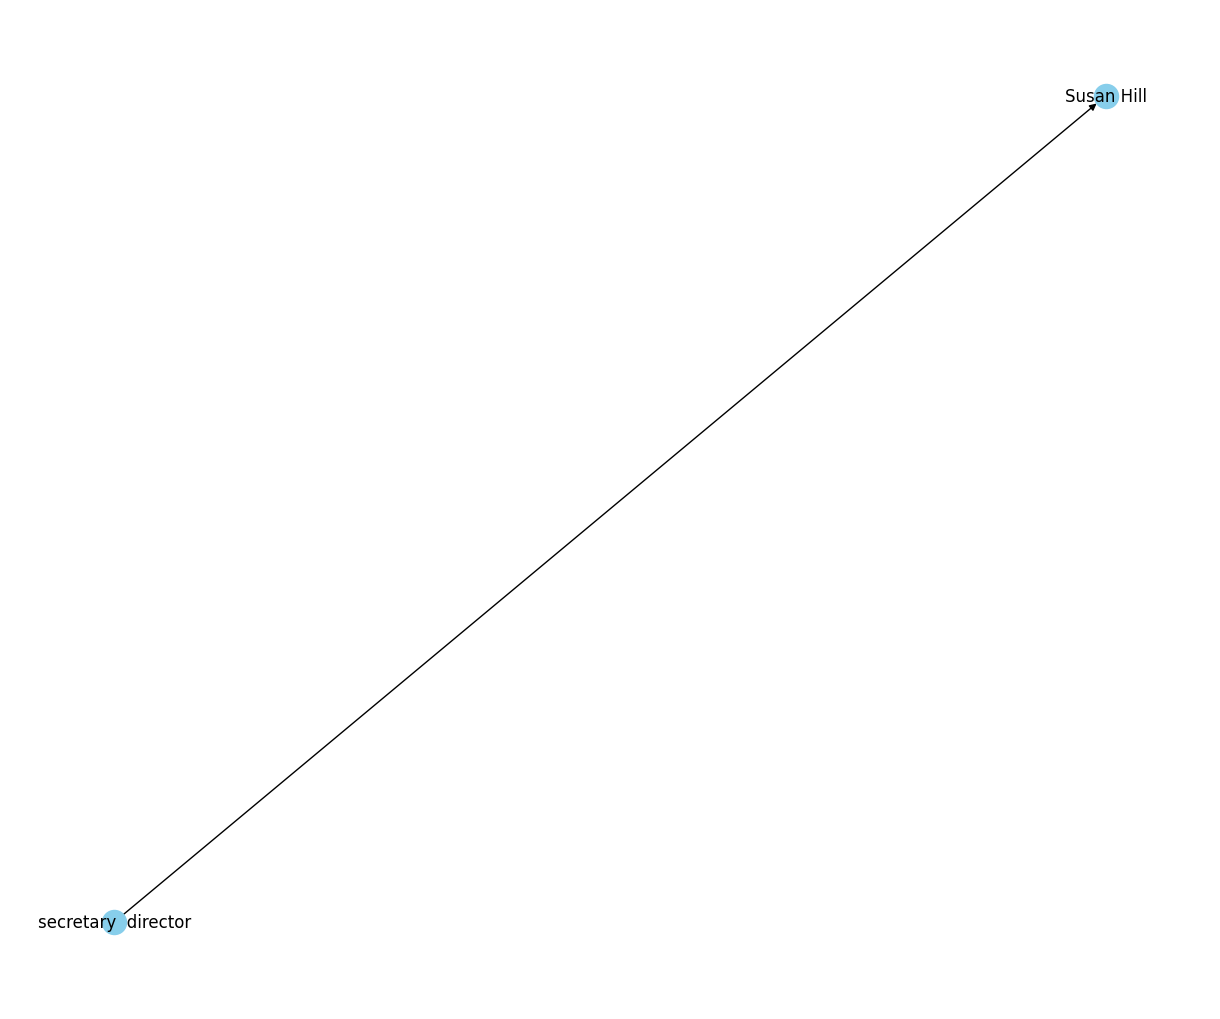

In [ ]:
plt.figure(figsize=(12,10))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

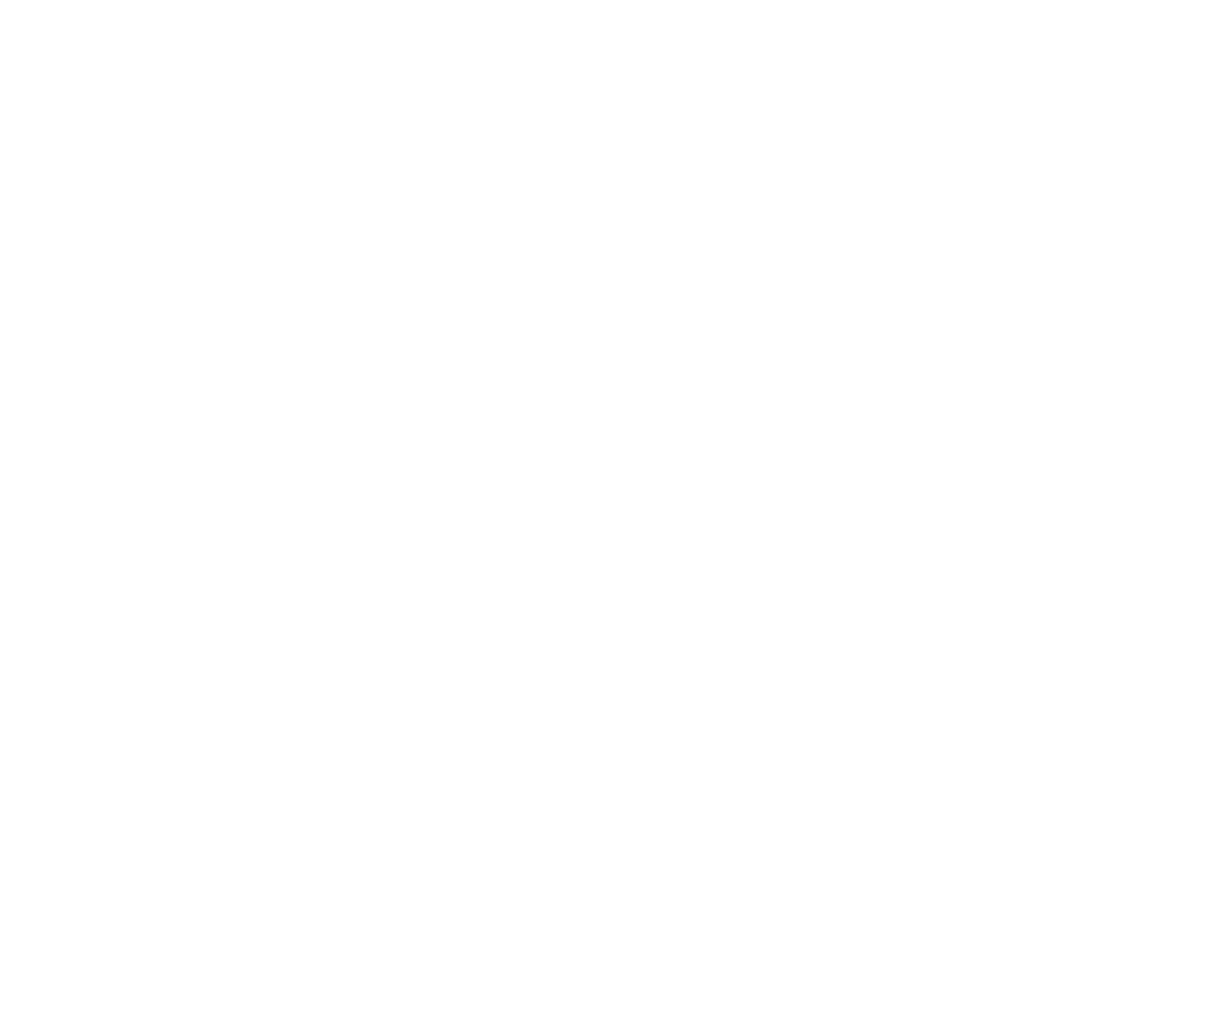

In [ ]:

G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="is"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,10))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()